# How to Perform Cross-Matches using Python


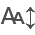

In [3]:
# Initial time
import time
initial_time = time.time()

# Packages
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from IPython.display import Image, display, Markdown
from itables import init_notebook_mode, show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Options
init_notebook_mode(all_interactive=True)
%matplotlib inline

## Introduction

In astronomy, a **cross-match** is the process of identifying the same astrophysical objects across different catalogs. This allows combining complementary data, such as photometry from one survey and astrometry from another.

**Common applications include:**

- Combine photometry from different catalogs (e.g., optical photometry combined with NIR photometry).  
- Combine astrometry with photometry.  
- Identify multi-wavelength counterparts (e.g., X-ray sources matched with optical or infrared catalogs).  
- Detect and classify variable stars across surveys.  
- Study stellar populations by combining chemical, photometric, and kinematic information.  
- Search for rare objects (e.g., brown dwarfs, white dwarfs) that appear in one survey but are faint or missing in another.  

In this talk, we focus on **Python-based approaches**, which provide reproducible and flexible tools for performing cross-matches efficiently.

## Data example

As an example for this talk, we will use data from the Cygnus OB2 association. Specifically, we will download data (using `astroquery`; see [PyCoffe_241030](https://github.com/PyCoffees/notebooks/blob/main/notebooks/2024_10_30_Astroquery_CarlosCifuentes.ipynb)) from a circular region with a radius of 0.5 degrees using the Gaia, Simbad, and ALS catalogs.

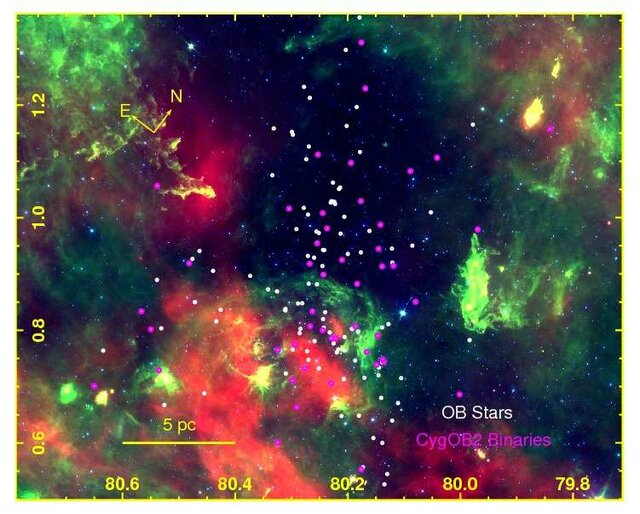

_Figure 1: Three-color image of Cygnus OB2 (Spitzer 4.5/8.0/24 µm). White symbols: O- and early B-type stars; magenta: 48 known binaries. Scale bar: 5 pc at 1.4 kpc. Figure extracted from Henry A. Kobulnicky et al. (2014)_

In [15]:
# Image of Cygnus OB2
display(Image(filename='/home/jmolina/Desktop/Juanan/AstroWork/PhD_CAB/MyJob/Other/PyCoffee/cygob2_image1.jpg'))

# Caption of Cygnus OB2
display(Markdown("_Figure 1: Three-color image of Cygnus OB2 (Spitzer 4.5/8.0/24 µm). White symbols: O- and early B-type stars; magenta: 48 known binaries. Scale bar: 5 pc at 1.4 kpc. Figure extracted from Henry A. Kobulnicky et al. (2014)_"))

In [4]:
# ============ Gaia ============
cygob2_gaia = pd.read_csv("cygob2_gaia", sep=r'\s+')
print(f"The Cygnus OB2 table contains {len(cygob2_gaia)} objects in Gaia.")
cygob2_gaia

The Cygnus OB2 table contains 32441 objects in Gaia.


source_id          ra        dec  phot_g_mean_mag  \
0      2064757320843133696  308.553854  40.875780        20.757215   
1      2064757325136864384  308.561689  40.882246        15.804086   
2      2064757389558934784  308.586729  40.889486        18.005390   
3      2064757389562618880  308.590690  40.897292        20.608683   
4      2064757393854598912  308.584477  40.891155        19.403334   
...                    ...         ...        ...              ...   
32436  2068042975117549824  307.897252  41.742336        20.340939   
32437  2068042975117929984  307.911168  41.745761        20.992077   
32438  2068042975118130048  307.899211  41.741372        21.012287   
32439  2068042975118562944  307.906826  41.743635        21.074287   
32440  2068042975119355136  307.907124  41.748856        16.304308   

       phot_bp_mean_mag  phot_rp_mean_mag  parallax      pmra     pmdec  
0             21.224201         18.962708 -4.119914 -4.430562 -4.452274  
1             16.599627         14.922846  0.927258 -4.163819 -9.358994  
2             19.192707         16.911667  0.684097  5.099045 -0.558545  
3             21.476444         19.254692 -1.394810 -3.111177 -5.216383  
4             20.907097         18.036050 -0.008341 -0.037784 -2.115862  
...                 ...               ...       ...       ...       ...  
32436         21.150390         18.951153  1.023945 -3.124489 -1.914371  
32437         21.067265         19.790419       NaN       NaN       NaN  
32438         22.186304         19.888632       NaN       NaN       NaN  
32439         20.706380         19.504590       NaN       NaN       NaN  
32440         19.506872         14.778800  0.435615 -2.472951 -5.477842  

[32441 rows x 9 columns]

In [5]:
# ============ Simbad ============
cygob2_simbad = pd.read_csv("cygob2_simbad", sep='\t')  # match how it was saved
print(f"The Cygnus OB2 table contains {len(cygob2_simbad)} objects.")
cygob2_simbad

The Cygnus OB2 table contains 4293 objects.


main_id          ra        dec  coo_err_maj  \
0     2MASS J20324109+4119552  308.171250  41.332000      70.0000   
1     2MASS J20325249+4115426  308.218708  41.261861     100.0000   
2     2MASS J20325828+4112511  308.242875  41.214222     240.0000   
3     2MASS J20330133+4110562  308.255542  41.182306     140.0000   
4     2MASS J20330150+4112116  308.256250  41.203250     150.0000   
...                       ...         ...        ...          ...   
4288  2MASS J20330739+4111505  308.280712  41.197463       2.2145   
4289  2MASS J20330880+4112151  308.286708  41.204194     150.0000   
4290               Schulte 12  308.170655  41.241466       0.0398   
4291              BD+40  4220  308.093433  41.305262       0.0176   
4292              Schulte  8C  308.324925  41.308665       0.0095   

      coo_err_min  coo_err_angle coo_wavelength          coo_bibcode       V  \
0         60.0000            0.0              I  2003yCat.2246....0C     NaN   
1         90.0000          175.0              I  2003yCat.2246....0C     NaN   
2        220.0000            4.0              I  2003yCat.2246....0C     NaN   
3        140.0000           90.0              I  2003yCat.2246....0C     NaN   
4        140.0000          174.0              I  2003yCat.2246....0C     NaN   
...           ...            ...            ...                  ...     ...   
4288       2.7660           90.0              O  2020yCat.1350....0G     NaN   
4289     140.0000          146.0              I  2003yCat.2246....0C     NaN   
4290       0.0479           90.0              O  2020yCat.1350....0G  11.702   
4291       0.0198           90.0              O  2020yCat.1350....0G   9.185   
4292       0.0116           90.0              O  2020yCat.1350....0G  10.190   

          B otype           sp_bibcode sp_qual      sp_type  
0       NaN     *                  NaN     NaN          NaN  
1       NaN     *                  NaN     NaN          NaN  
2       NaN     *                  NaN     NaN          NaN  
3       NaN     *                  NaN     NaN          NaN  
4       NaN     *                  NaN     NaN          NaN  
...     ...   ...                  ...     ...          ...  
4288    NaN     *                  NaN     NaN          NaN  
4289    NaN     *                  NaN     NaN          NaN  
4290  14.45   s*b  2012A&A...541A.145C       C      B3-4Ia+  
4291  10.61   s*b  2011ApJS..193...24S       C      O7Iafep  
4292  11.43     *  2010ApJ...711L.143W       C  O4.5III(fc)  

[4293 rows x 14 columns]

In [6]:
# ============ ALS ============
cygob2_als = Table.read("cygob2_als", format="ascii").to_pandas()
print(f"The Cygnus OB2 table contains {len(cygob2_als)} objects in ALS).")
cygob2_als

The Cygnus OB2 table contains 164 objects in ALS).


name        #             GOS ID         dist    posangc  \
0                 NaN      NaN                NaN          NaN        NaN   
1    ----------------  -------  -----------------  -----------  ---------   
2          ALS 15 106    00001    080.32+00.77_01      12.225'      27.20   
3          ALS 15 138    00002    080.15+00.94_01      12.818'     312.49   
4          ALS 15 142    00003    080.37+00.90_01      17.973'       3.17   
..                ...      ...                ...          ...        ...   
159        GLS 22 211    00158    080.18+01.12_01      23.290'     314.70   
160        GLS 22 465    00159    079.93+00.87_01      14.097'     251.58   
161        GLS 22 466    00160    080.43+00.82_01      19.301'      21.37   
162            WR 144    00161    080.04+00.93_01      13.030'     284.95   
163           Cyg X-3    00162    079.85+00.70_01      16.754'     209.89   

       gal    ALSf     Bap     Gap     Jap  ...    Aflag      RUWE  \
0      NaN     NaN     mag     mag     mag  ...      NaN       NaN   
1    -----  ------  ------  ------  ------  ...  -------  --------   
2        G       A    12.2    11.1     8.9  ...        G    23.539   
3        G       A    14.5    12.7    10.4  ...        G     1.555   
4        G       A    15.0    12.7    10.0  ...        G     7.331   
..     ...     ...     ...     ...     ...  ...      ...       ...   
159      G       G    15.9    13.8    11.3  ...        G    15.059   
160      G       G    16.3    13.0     9.8  ...        G     1.261   
161      G       G    16.1    13.1    10.1  ...        G     1.148   
162      G       G    16.3    12.9     9.4  ...        G     1.370   
163      G       G    30.0    30.0    15.3  ...        N       NaN   

            PMRA      sPMRA        PMdec     sPMdec        PMlon     sPMlon  \
0          mas/a      mas/a        mas/a      mas/a        mas/a      mas/a   
1    -----------  ---------  -----------  ---------  -----------  ---------   
2        -3.5367     0.8597      -3.1638     0.9204      -4.6483     2.0598   
3        -2.5851     0.0517      -4.2962     0.0565      -4.9923     0.1464   
4        -1.8085     0.2557      -4.9636     0.2977      -5.0653     0.7830   
..           ...        ...          ...        ...          ...        ...   
159      -2.3689     0.6867      -4.3548     0.7604      -4.9125     2.0385   
160      -2.8681     0.0386      -4.2309     0.0407      -5.1078     0.0609   
161      -2.5453     0.0290      -4.1583     0.0316      -4.8559     0.0398   
162      -2.6552     0.0464      -4.2450     0.0514      -4.9929     0.0857   
163          NaN        NaN          NaN        NaN          NaN        NaN   

          PMGlat   sPMGlat  
0          mas/a     mas/a  
1    -----------  --------  
2         0.9543    2.4175  
3        -0.4657    0.1564  
4        -1.5001    0.8945  
..           ...       ...  
159      -0.6656    2.4535  
160      -0.1944    0.0632  
161      -0.4361    0.0417  
162      -0.3751    0.0813  
163          NaN       NaN  

[164 rows x 56 columns]

## Cross-match by IDs

For this task, we will use the `merge` function from `pandas`.

In [7]:
def crossmatch_by_id(df1, df2, id1, id2):
    """
    Perform a cross-match between two dataframes based on identifiers.

    Parameters
    ----------
    df1 : pandas.DataFrame
        First dataframe containing an identifier column.
    df2 : pandas.DataFrame
        Second dataframe containing an identifier column.
    id1 : str
        Name of the identifier column in df1.
    id2 : str
        Name of the identifier column in df2.

    Returns
    -------
    only_df1 : pandas.DataFrame
        Rows in df1 that do not have a matching id in df2.
    only_df2 : pandas.DataFrame
        Rows in df2 that do not have a matching id in df1.
    common : pandas.DataFrame
        Rows where df1[id1] matches df2[id2], concatenated side by side.
    """
    # Ensure the ID columns are strings
    df1_copy = df1.copy()
    df2_copy = df2.copy()
    df1_copy[id1] = df1_copy[id1].astype(str)
    df2_copy[id2] = df2_copy[id2].astype(str)

    # Inner join to get common rows
    common = pd.merge(df1_copy, df2_copy, left_on=id1, right_on=id2, how='inner')

    # Left-only rows in df1
    only_df1 = (pd.merge(df1_copy, df2_copy[[id2]], left_on=id1, right_on=id2, how='left', indicator=True)
             .query('_merge == "left_only"')[df1_copy.columns].reset_index(drop=True))

    # Right-only rows in df2
    only_df2 = (pd.merge(df1_copy[[id1]], df2_copy, left_on=id1, right_on=id2, how='right', indicator=True)
             .query('_merge == "right_only"')[df2_copy.columns].reset_index(drop=True))

    return only_df1.reset_index(drop=True), only_df2.reset_index(drop=True), common.reset_index(drop=True)

In [8]:
# Perform id crossmatch between Gaia and ALS
only_gaia, only_als, common = crossmatch_by_id(
    cygob2_gaia,
    cygob2_als,
    id1='source_id',
    id2='Gaia'
)

# Check results
print("Sources only in Gaia:", len(only_gaia))
print("Sources only in ALS:", len(only_als))
print("Common sources:", len(common))

# Print result
common

Sources only in Gaia: 32285
Sources only in ALS: 8
Common sources: 156


source_id          ra        dec  phot_g_mean_mag  \
0    2067754731274151424  308.409227  40.894753        10.970627   
1    2067763080691028736  308.566845  41.038747        12.568740   
2    2067766276146708608  308.496865  41.093894        12.700013   
3    2067766379225921152  308.520238  41.086900        12.465465   
4    2067766684167207424  308.518105  41.135514        12.606314   
..                   ...         ...        ...              ...   
151  2067928660269306496  308.442132  41.550260         9.094592   
152  2067929450543312640  308.453291  41.627785        13.892073   
153  2067929686763411584  308.363005  41.599551        13.253365   
154  2067929794140714752  308.376303  41.599397        11.387851   
155  2067929862860202752  308.337451  41.597710        13.288143   

     phot_bp_mean_mag  phot_rp_mean_mag  parallax      pmra     pmdec  \
0           12.287193          9.844129  0.535332 -2.006020 -4.752351   
1           14.018986         11.393176  0.515647 -2.375493 -4.888436   
2           13.831216         11.645410  0.568583 -2.435545 -4.657440   
3           13.717407         11.363090  0.565545 -2.446115 -4.815535   
4           13.860584         11.501308  0.559651 -1.941939 -4.517577   
..                ...               ...       ...       ...       ...   
151         10.108875          8.026799  0.790828 -2.015776 -3.395375   
152         15.006828         12.836671  0.584434 -2.490408 -3.608222   
153         14.862413         12.032414  0.580524 -2.492628 -3.988557   
154         12.710186         10.257669  0.780503 -3.209480 -4.062920   
155         14.681749         12.132710  0.590197 -2.553016 -3.759906   

            name  ... Aflag    RUWE     PMRA   sPMRA    PMdec  sPMdec  \
0     GLS 22 071  ...     G   1.069  -2.0267  0.0365  -4.7086  0.0366   
1    Cyg OB2-A28  ...     G   1.279  -2.4040  0.0410  -4.8193  0.0423   
2     GLS 15 147  ...     G   1.170  -2.4642  0.0346  -4.5884  0.0358   
3     GLS 15 145  ...     G   1.241  -2.4742  0.0351  -4.7496  0.0377   
4     GLS 15 151  ...     G   1.111  -1.9706  0.0359  -4.4485  0.0373   
..           ...  ...   ...     ...      ...     ...      ...     ...   
151   Cyg OB2-10  ...     G  14.282  -2.0114  0.5345  -3.3653  0.6323   
152   GLS 15 189  ...     G   1.073  -2.4904  0.0299  -3.6082  0.0314   
153  Cyg OB2-B10  ...     G   1.066  -2.4926  0.0285  -3.9886  0.0310   
154   Cyg OB2-74  ...     G   2.155  -3.2328  0.0962  -4.0105  0.1113   
155   GLS 15 177  ...     G   1.204  -2.5530  0.0297  -3.7599  0.0314   

       PMlon  sPMlon   PMGlat sPMGlat  
0    -4.9888  0.0475  -1.1789  0.0525  
1    -5.3010  0.0664  -0.9513  0.0741  
2    -5.1523  0.0534  -0.7610  0.0586  
3    -5.2874  0.0567  -0.8506  0.0606  
4    -4.7452  0.0561  -1.0747  0.0622  
..       ...     ...      ...     ...  
151  -3.9010  1.6053  -0.3916  1.5928  
152  -4.3816  0.0372  -0.1524  0.0380  
153  -4.6886  0.0383  -0.3726  0.0381  
154  -5.1470  0.2683   0.2082  0.2694  
155  -4.5409  0.0390  -0.1866  0.0401  

[156 rows x 65 columns]

## Cross-match by coordinates

For this task, we will make use of the `SkyCoord` class from `astropy.coordinates`.

In [9]:
def make_coords(df):
    """
    Generate SkyCoord objects from a dataframe containing RA and DEC columns.

    The function automatically detects columns starting with 'ra', 'raj' for RA
    and 'dec', 'dej' for DEC. The first matching column for each is used.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the celestial coordinates.

    Returns
    -------
    astropy.coordinates.SkyCoord
        SkyCoord object with RA and DEC in degrees.

    Raises
    ------
    KeyError
        If no RA/DEC columns are found in the dataframe.
    """
    # Detect RA and DEC columns automatically
    ra_cols = [c for c in df.columns if c.lower().startswith(("ra"))]
    dec_cols = [c for c in df.columns if c.lower().startswith(("dec"))]

    if not ra_cols or not dec_cols:
        raise KeyError("No RA/DEC columns found in dataframe")

    # Create SkyCoord object
    return SkyCoord(ra=df[ra_cols[0]].values * u.deg,
                    dec=df[dec_cols[0]].values * u.deg)

def crossmatch_1to1(df1, df2, tol_arcsec=1.0):
    """
    Perform a 1-to-1 cross-match between two dataframes of celestial sources.

    Each source in df1 is matched to the closest source in df2 within a given
    tolerance. Only the best unique matches are returned (no df2 source is repeated).

    Parameters
    ----------
    df1, df2 : pandas.DataFrame
        DataFrames containing RA/DEC columns.
    tol_arcsec : float, optional
        Matching tolerance in arcseconds (default is 1.0").

    Returns
    -------
    only_df1 : pandas.DataFrame
        Sources only in df1 (not matched).
    only_df2 : pandas.DataFrame
        Sources only in df2 (not matched).
    common : pandas.DataFrame
        Matched sources, concatenated from df1 and df2 side by side.
    """
    # Convert dataframes to SkyCoord objects
    coords1 = make_coords(df1)
    coords2 = make_coords(df2)

    # Match each source in df1 to the closest in df2
    idx2, sep2d, _ = coords1.match_to_catalog_sky(coords2)
    mask = sep2d < tol_arcsec * u.arcsec 

    matched_idx1 = np.where(mask)[0]
    matched_idx2 = idx2[mask]

    # Sort by separation and keep only unique matches from df2
    order = np.argsort(sep2d[mask].arcsec)
    matched_idx1 = matched_idx1[order]
    matched_idx2 = matched_idx2[order]

    _, unique_idx = np.unique(matched_idx2, return_index=True)
    best_idx1 = matched_idx1[unique_idx]
    best_idx2 = matched_idx2[unique_idx]

    # Build output dataframes
    common = pd.concat([df1.iloc[best_idx1].reset_index(drop=True),
                        df2.iloc[best_idx2].reset_index(drop=True)], axis=1)
    only_df1 = df1.drop(best_idx1).reset_index(drop=True)
    only_df2 = df2.drop(best_idx2).reset_index(drop=True)

    return only_df1, only_df2, common

In [10]:
# Perform 1-to-1 crossmatch between Gaia and 2MASS
only_gaia, only_simbad, common = crossmatch_1to1(cygob2_gaia, cygob2_simbad, tol_arcsec=1.0)

# Check results
print("Sources only in Gaia:", len(only_gaia))
print("Sources only in Simbad:", len(only_simbad))
print("Common sources:", len(common))

# Print result
common

Sources only in Gaia: 29168
Sources only in Simbad: 1020
Common sources: 3273


source_id          ra        dec  phot_g_mean_mag  \
0     2067830563214552320  308.171111  41.332071        19.404251   
1     2067784585590487296  308.306651  41.297068        18.252298   
2     2067783387298235904  308.331066  41.230497        19.756401   
3     2067784177567615104  308.341432  41.292093        19.547056   
4     2067816230907842432  307.714619  41.295002        17.863825   
...                   ...         ...        ...              ...   
3268  2067830941174419968  308.088928  41.309837        14.100558   
3269  2067781806749285504  308.280712  41.197463        20.972446   
3270  2067782734461462912  308.170645  41.241451         8.874314   
3271  2067830941174418048  308.093416  41.305244         8.232017   
3272  2067784246289931776  308.324910  41.308646         9.484826   

      phot_bp_mean_mag  phot_rp_mean_mag  parallax      pmra     pmdec  \
0             0.676582         -2.632392 -4.235706       NaN       NaN   
1            19.570326         17.120708  0.823911 -0.062476 -3.104362   
2            21.110085         18.198593  0.616687 -2.286562 -3.341229   
3            20.891785         17.810946  0.833790 -3.549964 -3.866897   
4            20.057837         16.468863  0.501677 -2.449806 -4.093075   
...                ...               ...       ...       ...       ...   
3268         15.227328         13.045171  0.571722 -2.797708 -4.160078   
3269         21.524380         19.631294       NaN       NaN       NaN   
3270         11.615227          7.448345  0.589540 -1.703481 -3.412027   
3271          9.385777          7.050828  0.538034 -2.850265 -4.107003   
3272         10.349748          8.551971  0.593184 -2.631085 -4.399818   

                      main_id  ...  coo_err_min  coo_err_angle  \
0     2MASS J20324109+4119552  ...      60.0000            0.0   
1     2MASS J20331359+4117497  ...      70.0000           90.0   
2     2MASS J20331943+4113495  ...      60.0000          173.0   
3     2MASS J20332194+4117317  ...      60.0000            0.0   
4     2MASS J20305152+4117421  ...      60.0000            0.0   
...                       ...  ...          ...            ...   
3268  2MASS J20322135+4118354  ...       0.0132           90.0   
3269  2MASS J20330739+4111505  ...       2.7660           90.0   
3270               Schulte 12  ...       0.0479           90.0   
3271              BD+40  4220  ...       0.0198           90.0   
3272              Schulte  8C  ...       0.0116           90.0   

      coo_wavelength          coo_bibcode       V          B otype  \
0                  I  2003yCat.2246....0C     NaN        NaN     *   
1                  I  2003yCat.2246....0C     NaN        NaN     *   
2                  I  2003yCat.2246....0C     NaN        NaN     *   
3                  I  2003yCat.2246....0C     NaN        NaN     *   
4                  N  2003yCat.2246....0C     NaN        NaN     *   
...              ...                  ...     ...        ...   ...   
3268               O  2020yCat.1350....0G  14.910  16.709999     *   
3269               O  2020yCat.1350....0G     NaN        NaN     *   
3270               O  2020yCat.1350....0G  11.702  14.450000   s*b   
3271               O  2020yCat.1350....0G   9.185  10.610000   s*b   
3272               O  2020yCat.1350....0G  10.190  11.430000     *   

               sp_bibcode  sp_qual      sp_type  
0                     NaN      NaN          NaN  
1                     NaN      NaN          NaN  
2                     NaN      NaN          NaN  
3                     NaN      NaN          NaN  
4                     NaN      NaN          NaN  
...                   ...      ...          ...  
3268  2007ApJ...664.1102K        D          B1V  
3269                  NaN      NaN          NaN  
3270  2012A&A...541A.145C        C      B3-4Ia+  
3271  2011ApJS..193...24S        C      O7Iafep  
3272  2010ApJ...711L.143W        C  O4.5III(fc)  

[3273 rows x 23 columns]

## Some comprobations

We can perform possible checks to see the effectiveness of our cross-matches. One of them is to compare similar photometric bands and see if they follow the expected trend.

In [11]:
# Specific case
df1 = cygob2_gaia
df2 = cygob2_simbad
tol_arcsec = 1.0

# Convert dataframes to SkyCoord objects
coords1 = make_coords(df1)
coords2 = make_coords(df2)

# Match each source in df1 to the closest in df2
idx2, sep2d, _ = coords1.match_to_catalog_sky(coords2)
mask = sep2d < tol_arcsec * u.arcsec

matched_idx1 = np.where(mask)[0]
matched_idx2 = idx2[mask]

# Sort by separation and keep only unique matches from df2
order = np.argsort(sep2d[mask].arcsec)
matched_idx1 = matched_idx1[order]
matched_idx2 = matched_idx2[order]

_, unique_idx = np.unique(matched_idx2, return_index=True)
best_idx1 = matched_idx1[unique_idx]
best_idx2 = matched_idx2[unique_idx]

# Build output dataframes
common = pd.concat([df1.iloc[best_idx1].reset_index(drop=True),
                    df2.iloc[best_idx2].reset_index(drop=True)], axis=1)
only_df1 = df1.drop(best_idx1).reset_index(drop=True)
only_df2 = df2.drop(best_idx2).reset_index(drop=True)

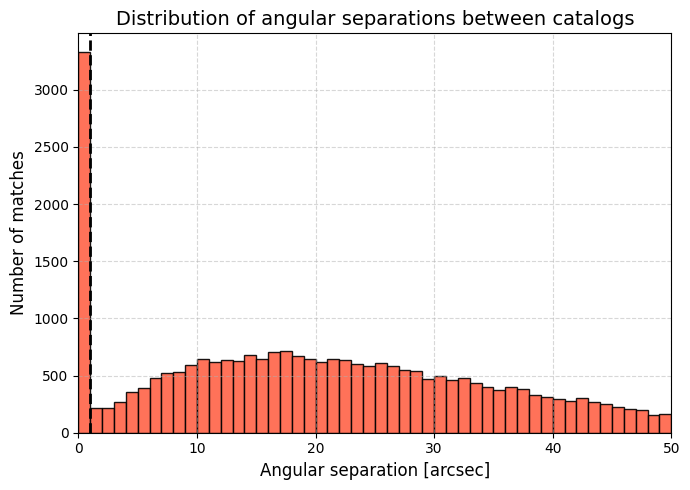

In [12]:
# Plot: Separations in arcseconds
data = sep2d.arcsec

# Define bins of 1 arcsec
n_bins = 50
bins = np.arange(0, n_bins+1, 1)

plt.figure(figsize=(7,5))
plt.hist(data, bins=bins, color='tomato', edgecolor='black', alpha=0.9)
plt.axvline(x=1, color='black', linestyle='--', linewidth=2)

plt.xlabel("Angular separation [arcsec]", fontsize=12)
plt.ylabel("Number of matches", fontsize=12)
plt.title("Distribution of angular separations between catalogs", fontsize=14)

plt.xlim(0,n_bins)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

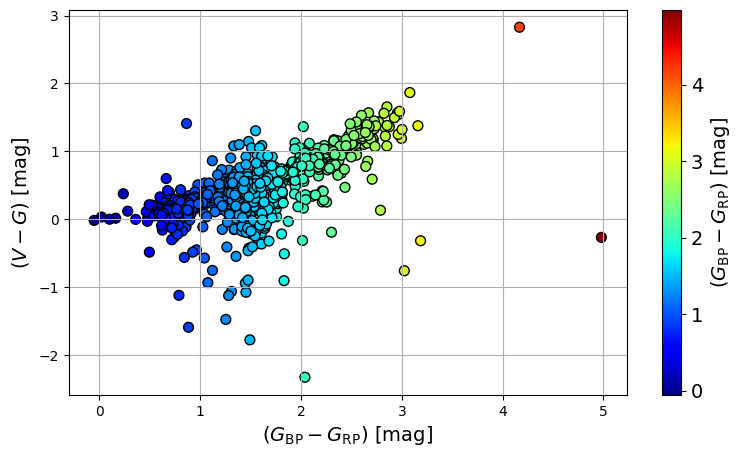

In [13]:
# Variables
bp_rp = common['phot_bp_mean_mag'] - common['phot_rp_mean_mag']
v_g   = common['V'] - common['phot_g_mean_mag']

# Filter out NaNs or infinite values
mask = np.isfinite(bp_rp) & np.isfinite(v_g)
bp_rp = bp_rp[mask]
v_g = v_g[mask]

# Plot: Magnitude V - G check
plt.figure(figsize=(9,5))
sc = plt.scatter(bp_rp, v_g, c=bp_rp, cmap='jet', s=50, alpha=1.0, edgecolor='black')
plt.xlabel(r'$(G_\mathrm{BP} - G_\mathrm{RP})\ [\mathrm{mag}]$', fontsize=14)
plt.ylabel(r'$(V - G)\ [\mathrm{mag}]$', fontsize=14)
plt.grid(True)

# Colorbar
cbar = plt.colorbar(sc)
cbar.set_label(r'$(G_\mathrm{BP} - G_\mathrm{RP})\ [\mathrm{mag}]$', fontsize=14)
cbar.ax.tick_params(labelsize=14) 
plt.show()

## Possible issues

When performing cross-matches between different catalogues, some issues can arise. Some of the most common ones include:

- Catalogues have different spatial resolutions, which can result in a single object being catalogued as two separate sources.
- The coordinates of an object with high proper motion can differ between catalogues.
- In large catalogues, errors are common, such as inaccurate coordinates, duplicate sources, or the same object listed under different names, etc.

## Alternatives to Python

Besides Python, there are other tools and software that can be used for cross-matching astronomical catalogues. 

- TOPCAT provides a user-friendly graphical interface for matching large datasets
- Aladin allows interactive cross-identification of objects with visual inspection.
- Some databases, such as VizieR and SIMBAD, also offer built-in cross-match services directly on the web.

In [13]:
# Final time
final_time = time.time()
elapsed_time = (final_time - initial_time) / 60
print(f"Execution Time: {elapsed_time:.2f} minutes")

Execution Time: 0.03 minutes
